First we query each dataset to create a dictionary containing variables as keys and dataset ids as values. We also create a dictionary with variables as keys and variables WITH their respective units as values. This is because when querying ERDDAP we are not required to specify units, however when the csv is saved the units are saved. Having this dictionary allows us to more easily plot the variables later on.

In [1]:
import pandas as pd
import os
from erddapy import ERDDAP
import numpy as np
import re

IDlist = [
            'FORCE_Mar2018_ADCP_Currents',
    'FORCE_Mar2018_ADCP_Waves',
    'force_3b1e_d478_b537'
]

e = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
e.auth = ("cioosatlantic", "4oceans")
e.response = "csv"
datasetdict = {}
unitdict = {}
for val in IDlist:
    e.dataset_id = val
    e.constraints = { "time<=": "2018-03-30T20:17:33Z",
                    }
    df = e.to_pandas()
    
    for col in df.columns:  
        if len(df[col].unique()) == 1: 
            df.drop([col], axis=1, inplace=True) 
    
    variables = list(df.columns)
    for i in range(len(variables)):
        variables[i] =  re.sub(r'\(.*?\) *', '', variables[i])
        
    variablelist = list(df.columns)
    newdict = dict(zip(variables, variablelist))
    unitdict.update(newdict)
    

    for i in range(len(variables)):
        datasetdict[variables[i]] = val
del unitdict['time ']        
print(datasetdict)
print(unitdict)

{'time ': 'force_3b1e_d478_b537', 'cell_range ': 'FORCE_Mar2018_ADCP_Currents', 'eastward_sea_water_velocity ': 'FORCE_Mar2018_ADCP_Currents', 'northward_sea_water_velocity ': 'FORCE_Mar2018_ADCP_Currents', 'upward_sea_water_velocity ': 'FORCE_Mar2018_ADCP_Currents', 'speed_of_sound_in_sea_water ': 'FORCE_Mar2018_ADCP_Currents', 'sea_water_temperature ': 'FORCE_Mar2018_ADCP_Currents', 'sea_water_pressure ': 'FORCE_Mar2018_ADCP_Waves', 'sea_surface_wave_significant_height ': 'FORCE_Mar2018_ADCP_Waves', 'sea_surface_wave_maximum_period ': 'FORCE_Mar2018_ADCP_Waves', 'batt_volt': 'force_3b1e_d478_b537', 'AirTemp_C': 'force_3b1e_d478_b537', 'Solar_kW': 'force_3b1e_d478_b537', 'RH': 'force_3b1e_d478_b537', 'WS_ms': 'force_3b1e_d478_b537', 'PTemp': 'force_3b1e_d478_b537', 'WS_15min_max': 'force_3b1e_d478_b537', 'Solar_Raw': 'force_3b1e_d478_b537', 'Bar_mbar': 'force_3b1e_d478_b537', 'Solar_MJ': 'force_3b1e_d478_b537', 'Max_WS_2min': 'force_3b1e_d478_b537', 'Pressure_Raw': 'force_3b1e_d478_b5

In [2]:
def getdata(varname):
    e = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
    e.auth = ("cioosatlantic", "4oceans")
    e.response = "csv"
    e.dataset_id = datasetdict.get(varname)
    e.variables = ['time', varname]
    e.constraints = {"time<=": "2018-05-23T17:47:30Z", "time>=": '2018-03-30T20:02:33Z'}
    df = e.to_pandas()
    df = df.sort_values(by=['time (UTC)'])
    df['time (UTC)'] = pd.to_datetime(df['time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
    df = df.set_index(df['time (UTC)'].astype(np.datetime64))
    if varname == 'eastward_sea_water_velocity ' or 'upward_sea_water_velocity ' or 'northward_sea_water_velocity ':
        df = df[df[unitdict[varname]] !=0]
    if varname == 'sea_surface_wave_maximum_period ':
        df = df[df[unitdict[varname]] !=-9]
    return df

Row(background='#dbefe1')
    [0] Column
        [0] PNG(str, align='center', height=350, sizing_mode='fixed', width=350)
        [1] VSpacer()
        [2] HoloViews(Overlay)
        [3] VSpacer()
        [4] PNG(str, align='center', width=300)
        [5] SVG(str, align='center', link_url='https://cioosatlantic.ca/..., width=350)
    [1] Spacer(width=20)
    [2] Column
        [0] Row
            [0] Markdown(str, background='#dbefe1', style={'font-size': '50px', ...}, width=750)
            [1] Spacer(width=610)
            [2] HTML(str)
        [1] Divider()
        [2] Row
            [0] Column
                [0] Select(options=['cell_range ', ...], value='cell_range ')
                [1] Row
                    [0] DatetimePicker(enable_time=False, end=datetime.date(2018, ..., name='Start:', start=datetime.date(2018, ..., value=datetime.datetime(2018, ...)
                    [1] DatetimePicker(enable_time=False, end=datetime.date(2018, ..., name='End:', start=datetime.date(2018, ..., value=datetime.datetime(2018, ...)
                [2] Button(button_type='primary', name='Update')
                [3] HoloViews(Layout)
            [1] Spacer(width=20)
            [2] Column
                [0] Column(sizing_mode='stretch_width', width=225)
                    [0] Column(sizing_mode='stretch_width', width=225)
                        [0] DatetimePicker(enable_time=False, end=datetime.date(2018, ..., name='Start:', start=datetime.date(2018, ..., value=datetime.datetime(2018, ...)
                        [1] DatetimePicker(enable_time=False, end=datetime.date(2018, ..., name='End:', start=datetime.date(2018, ..., value=datetime.datetime(2018, ...)
                    [1] Button(button_type='primary', name='Update')
                [1] HoloViews(Layout)
            [3] Spacer(width=20)
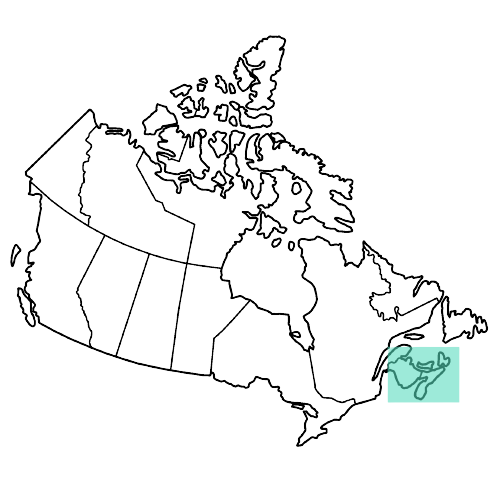
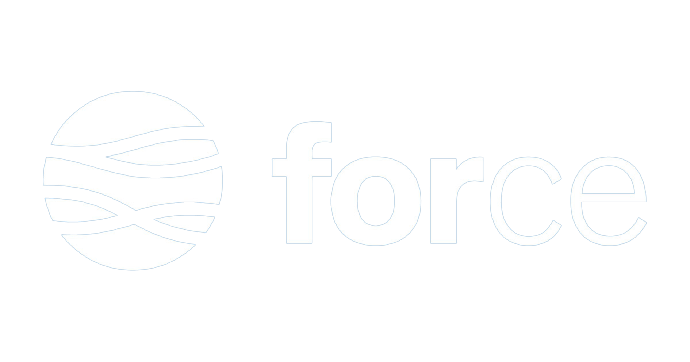

In [9]:
import datetime as dt
import hvplot.pandas
import panel as pn
from holoviews import opts
import datashader as ds
import holoviews.operation.datashader as hd
from bokeh.models.formatters import DatetimeTickFormatter
import holoviews as hv
pn.extension(css_files=['https://fonts.googleapis.com/css?family=Quicksand'])


opts = dict(show_grid=True, frame_height=350, frame_width=800,shared_axes=False,
            xformatter=DatetimeTickFormatter(months='%b %Y' ,days="%b/%d",hours="%H:%M",minutes="%H:%M"), tools = ["hover"], bgcolor='white')


def plotVar(varname, start, end):
    data = getdata(varname)
    start = dt.date(start.year,start.month,start.day)
    end = dt.date(end.year,end.month,end.day)
    data = data.loc[start:end]
    
    plot = data.hvplot.scatter(x = 'time (UTC)', y = unitdict[varname] , datashade = True, aggregator = 'mean').opts(**opts)
    spreadplot = hd.dynspread(plot, threshold=.999, max_px=2)
    histogram = data.hvplot.hist(unitdict[varname], width =860,height=250, bins = 100, normed = True, ).opts(show_grid=True, shared_axes=False)
    plots = (spreadplot+histogram).opts(toolbar='right')
    return plots.cols(1)


var_selector = pn.widgets.Select(name = "Select Variable:", options = list(unitdict.keys()), value = list(unitdict.keys())[0] )

date_picker_start = pn.widgets.DatetimePicker(name='Start:', 
                        enable_time=False,
                        start=dt.date(2018, 3, 30), 
                        end = dt.date(2018,5,24), 
                        value = dt.datetime(2018,4,1)                      
                                             )

date_picker_end = pn.widgets.DatetimePicker(name='End:',
                        enable_time=False, 
                        start=dt.date(2018, 3, 30), 
                        end = dt.date(2018,5,24), 
                        value = dt.datetime(2018,4,7)
                                           )
def update(event):
    main.loading = True
    main[3].object = plotVar(var_selector.value,date_picker_start.value, date_picker_end.value)
    main.loading=False


button = pn.widgets.Button(name="Update", button_type="primary")
button.on_click(update)

plotpane = pn.pane.HoloViews(plotVar(var_selector.value,date_picker_start.value, date_picker_end.value))
main = pn.Column(var_selector ,pn.Row(date_picker_start,date_picker_end),button ,plotpane)

###

tileopts = hv.opts.Tiles(width=365, height=350, projection=True )
tiles = hv.element.tiles.OSM().opts(tileopts)
gdata =[[-7172033.398401788, 5678872.595825182]]
geodata = pd.DataFrame(gdata, columns = ['x','y'])
geoplot = geodata.hvplot.points('x','y', color='red', alpha = 1).opts(width=365, height=350, size=5)
mapplot = (tiles*geoplot).options(xlim=(-7.05e6, -7e6), ylim=(5.2e6, 6e6), aspect='equal', xaxis=None,yaxis=None,
                                      active_tools=['pan', 'wheel_zoom'], toolbar=None)

geopane = pn.pane.HoloViews(mapplot)
###

c = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
c.auth = ("cioosatlantic", "4oceans")
c.response = "csv"
c.dataset_id = 'FORCE_Mar2018_ADCP_Currents'
c.constraints = { "time<=": "2018-05-23T17:47:30Z", 
                  "time>=": '2018-03-30T20:02:33Z',
                 "eastward_sea_water_velocity!=":0,
               #  "upward_sea_water_velocity!=":0,
                 "northward_sea_water_velocity!=":0,
                }
c.variables = ['time',
               'eastward_sea_water_velocity',
               'northward_sea_water_velocity',
               'cell_range'
               ]
df1 = c.to_pandas()
df1['time (UTC)'] = pd.to_datetime(df1['time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
###

X = df1.iloc[:,1:3].values
covariance_matrix = np.cov(X.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)

cumulative_variance_explained = np.cumsum(variance_explained)

projection_matrix = (eigen_vectors.T[:][:1]).T

X_pca = X.dot(projection_matrix)

df_pca = pd.DataFrame(X_pca, columns = ['Channel Velocity (m/s)'])

fulldata = pd.concat([df1, df_pca], axis=1)
fulldata = fulldata.sort_values(by=['time (UTC)'])
fulldata = fulldata.set_index(fulldata['time (UTC)'].astype(np.datetime64))
fulldata.index.name = 'time'


def channelplot(start, end):
    data1 = fulldata.copy()
    start = dt.date(start.year,start.month,start.day)
    end = dt.date(end.year,end.month,end.day)
    data = data1.loc[start:end]
    
    scatter = data.hvplot.scatter(x = 'time (UTC)', y=['Channel Velocity (m/s)'], cmap = 'Reds'
                               ,datashade=True,height=335, width=510,aggregator = 'mean').opts(
                                    tools=['hover'],xformatter=DatetimeTickFormatter(months='%b %Y' ,days="%b/%d",hours="%H:%M",minutes="%H:%M"))

    channelplot = hd.dynspread(scatter, threshold=.999, max_px=2).opts(show_grid=True)
    
    heatmap = data.hvplot.heatmap(x='time (UTC)',y='cell_range (m)', C = 'Channel Velocity (m/s)',height=335, 
                                  width=510, colorbar=True, cmap = 'Spectral', clim = (-3,3), 
                                     ylim =(0,data['cell_range (m)'].max()) ).opts(show_grid=True,
                                    tools=['hover'],xformatter=DatetimeTickFormatter(months='%b %Y' ,days="%b/%d",hours="%H:%M",minutes="%H:%M"))
    
    channel_plots = (channelplot + heatmap).opts(toolbar='right')
    return channel_plots.cols(1)

    
    return heatmap.aggregate(function=np.mean)


date_picker_start2 = pn.widgets.DatetimePicker(name='Start:', 
                        enable_time=False,
                        start=dt.date(2018, 3, 30), 
                        end = dt.date(2018,5,24), 
                        value = dt.datetime(2018,4,1)                      
                                             )

date_picker_end2 = pn.widgets.DatetimePicker(name='End:',
                        enable_time=False, 
                        start=dt.date(2018, 3, 30), 
                        end = dt.date(2018,5,24), 
                        value = dt.datetime(2018,4,7))

button2 = pn.widgets.Button(name='Update', button_type = 'primary')


def updatechannel(event):
    channelpane.loading = True
    channel[1].object = channelplot(date_picker_start2.value, date_picker_end2.value)
    channelpane.loading= False


button2.on_click(updatechannel)
    
times = pn.Column(pn.Column(date_picker_start2,date_picker_end2,width = 225,sizing_mode = 'stretch_width'),
                  button2, width = 225, sizing_mode = 'stretch_width')
channelpane = pn.pane.HoloViews(channelplot(date_picker_start2.value, date_picker_end2.value))

channel = pn.Column(times,channelpane)
###

moreinfo = pn.pane.HTML(""" 
<link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.6.1/css/all.css">

<style>
.tooltip {
  position: relative;
  display: inline-block;
}

.tooltip .tooltiptext {
  visibility: hidden;
  width: 600px;
  background-color: black;
  color: #fff;
  text-align: center;
  border-radius: 6px;
  padding: 5px 0;
  position: absolute;
  z-index: 1;
  top: -5px;
  right: 110%;
}

.tooltip .tooltiptext::after {
  content: "";
  position: absolute;
  top: 50%;
  left: 100%;
  margin-top: -5px;
  border-width: 5px;
  border-style: solid;
  border-color: transparent black transparent transparent;
}
.tooltip:hover .tooltiptext {
  visibility: visible;
}
</style>
<body style="text-align:center;">

<a href="https://github.com/RineZaman/FORCE-Visualization" target="_blank" title="GitHub Repository"><i class="fab fa-github" style='font-size:30px'></i></a>
<a href="https://twitter.com/CIOOSAtlantic?s=20" target="_blank" title="Twitter"><i class="fab fa-twitter-square" style='font-size:30px'></i>
<div class="tooltip">
  
  <a href="https://dev.cioosatlantic.ca/erddap/search/advanced.html?page=1&itemsPerPage=1000&searchFor=FORCE&protocol=%28ANY%29&cdm_data_type=%28ANY%29&institution=%28ANY%29&ioos_category=%28ANY%29&keywords=%28ANY%29&long_name=%28ANY%29&standard_name=%28ANY%29&variableName=%28ANY%29&maxLat=&minLon=&maxLon=&minLat=&minTime=&maxTime=" target="_blank" ><i class="fas fa-info-circle" style='font-size:30px'></i>

  <span class="tooltiptext">This seabed-mounted ADCP, deployed for two months in spring 2018, collected 3-D velocity profiles and surface wave statistics at a location within the FORCE Crown Lease Area. Data are provided in raw (*ad2cp) form, and as processed currents and waves. These data were collected as part of a project on evaluating fish sensor capabilities at high flow sites.</span>
</div>
<p>ERDDAP Access</p>
</body>
""", align = 'start')
###

titlepane = pn.pane.Markdown('FORCE ADCP Data Visualization',align='start',style={'font-size':'50px', 'font-family':'Quicksand'}, background='#dbefe1',width = 750,)
ciooslogo = pn.pane.SVG('https://cioosatlantic.ca/wp-content/themes/cioos-siooc-wordpress-theme/img/atlantic/cioos-atlantic_EN.svg?x70378'
                   , width=350, link_url="https://cioosatlantic.ca/", align='center')
if os.path.exists("canadamap.png"):
    canadamap = pn.panel("canadamap.png", height=350, width=350, align='center')

if os.path.exists("FORCE_logo.png"):
    forcelogo = pn.panel("FORCE_logo.png",  width=300, align='center')
    
col1 = pn.Column(canadamap,pn.layout.VSpacer(),geopane,pn.layout.VSpacer(),forcelogo,ciooslogo)
row1 = pn.Row(titlepane,pn.Spacer(width=610),moreinfo)
row2 = pn.Row(main, pn.Spacer(width=20),channel,pn.Spacer(width=20))
col2 = pn.Column(row1,pn.layout.Divider(),row2)
dashboard = pn.Row(col1,pn.Spacer(width=20),col2,background='#dbefe1', )

dashboard.servable()